# SeSiMe
### Sentence/Sequence Similarity Measure

### (2) Mass spec side
Import MS data and create documents.

Here: Use NOT Crusemann data, but other dataset where smilea are known for all spectra.
### here: GNPS Dataset of 11134 spectra with smiles.

In [1]:
# data locations
# Windows 
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
spectra = load_spectra(mgf_file)

Loaded 11134 molecules


In [4]:
# Load metadata (mostly needed later on: smiles)
from parsers import LoadMGF
ms1, ms2, metadata = LoadMGF(name_field='scans').load_spectra([mgf_file])

for spec in spectra:
    id = spec.spectrum_id
    spec.metadata = metadata[id]

## Inspecting the data

In [5]:
def peak_stats(spectra):
    peak_count = []
    parent_count = []
    rel_to_max_count = []

    for spec in spectra:
        peak_count.append(len(spec.peaks))
        parent_count.append(spec.precursor_mz)
        peak_ints = np.array(spec.peaks)[:,1]
        rel_to_max_count.append(len(np.where(peak_ints < 0.01*np.max(peak_ints))[0]))
        
    return peak_count, parent_count, rel_to_max_count

peak_count, parent_count, rel_to_max_count = peak_stats(spectra)

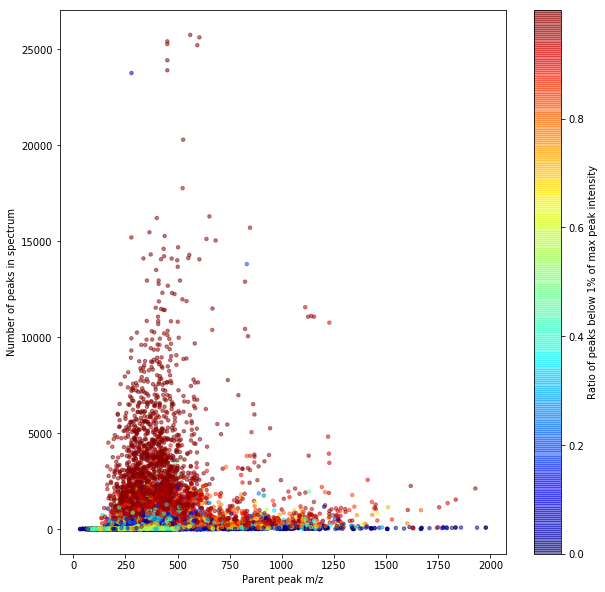

In [6]:
# plot relationship PARENT-MASS vs NUMBER OF PEAKS
from matplotlib import pyplot as plt
%matplotlib inline  

def plot_peak_stats(peak_count, parent_count, rel_to_max_count):
    fig = plt.figure(figsize=(10,10))
    plt.scatter(parent_count, peak_count, s=12, c= np.array(rel_to_max_count)/peak_count, alpha=0.5, cmap="jet")
    plt.xlabel("Parent peak m/z")
    plt.ylabel("Number of peaks in spectrum")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Ratio of peaks below 1% of max peak intensity", rotation=90)
    plt.show()
  
plot_peak_stats(peak_count, parent_count, rel_to_max_count)   

### Problems: 
- **To hetergeneous document lengths**. 

We here have spectra ranging from 1 to 25.000 peaks, which would lead to *vastly* different document lengths.

- **Spectra with too few peaks**

Below a certain number of peaks, spectra will become useless for further quantitative analysis...

In [7]:
print("No. of spectra with 10 or less peaks: ", len(np.where(np.array(peak_count) <= 10)[0]))
print("No. of spectra with 5 or less peaks: ", len(np.where(np.array(peak_count) <= 5)[0]))
print("No. of spectra with 3 or less peaks: ", len(np.where(np.array(peak_count) <= 3)[0]))

No. of spectra with 10 or less peaks:  1730
No. of spectra with 5 or less peaks:  909
No. of spectra with 3 or less peaks:  549


## Some first tests:
Try out to get a more homogeneous and reasonable number of peaks per spectrum.


### (1) Apply intensity threshold relative to highest peak
(here: discard peaks with intensities < 1% of highest peak) 

In [8]:
import copy
spectra2 = copy.deepcopy(spectra)

# TEST: try to scale the amount of filtering with the number of peaks present
def threshold_scaling(x, xfactor, peaks_desired):
    return (x - peaks_desired)**xfactor

for spec in spectra2:
    peaks = spec.peaks.copy()
    peaks_desired = 100
    if len(peaks) > peaks_desired:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 1.0,
                     exp_intensity_filter = None, #threshold_scaling(len(peaks), -0.6, peaks_desired),#0.01,
                     min_peaks = 50,)

    spec.peaks = peaks

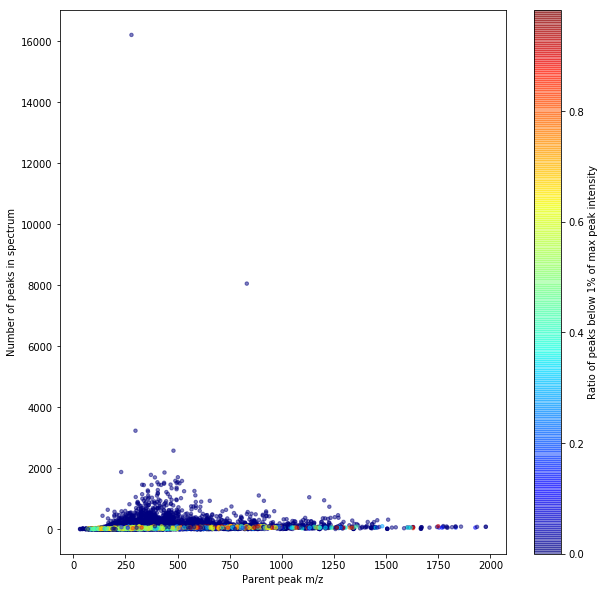

In [9]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)
plot_peak_stats(peak_count, parent_count, rel_to_max_count) 

### (2) Apply the intensity distribution based exponential cutoff filter 


In [10]:
spectra2 = copy.deepcopy(spectra)

min_peaks = 50

for spec in spectra2:
    peaks = spec.peaks.copy()
    if len(peaks) > min_peaks:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 0.0,
                     exp_intensity_filter = 0.01,
                     min_peaks = min_peaks,)

    spec.peaks = peaks

RuntimeError for  123  peaks. Use mean intensity as threshold.


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\MS_functions.py:190: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\scipy\optimize\minpack.py:780: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq


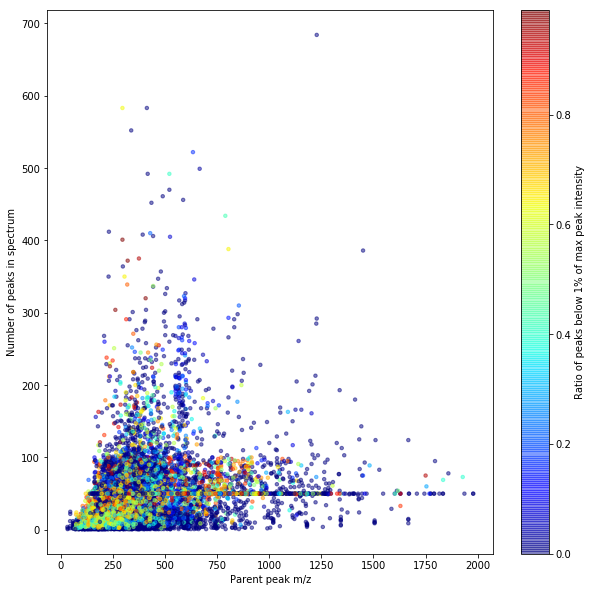

In [11]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)

plot_peak_stats(peak_count, parent_count, rel_to_max_count)  

### (3) Apply the intensity distribution based exponential cutoff filter 
(+ amount of filtering varies with number of peaks)

--> Actually doesn't really look much better than the previous approach.

In [12]:
spectra2 = copy.deepcopy(spectra)

# TEST: try to scale the amount of filtering with the number of peaks present
def threshold_scaling(x, xfactor, peaks_desired):
    return (x - peaks_desired)**xfactor

peaks_desired = 100
min_peaks = 50

for spec in spectra2:
    peaks = spec.peaks.copy()
    if len(peaks) > peaks_desired:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 0.0,
                     exp_intensity_filter = threshold_scaling(len(peaks), -0.6, peaks_desired),#0.01,
                     min_peaks = min_peaks,)

    spec.peaks = peaks

RuntimeError for  123  peaks. Use mean intensity as threshold.


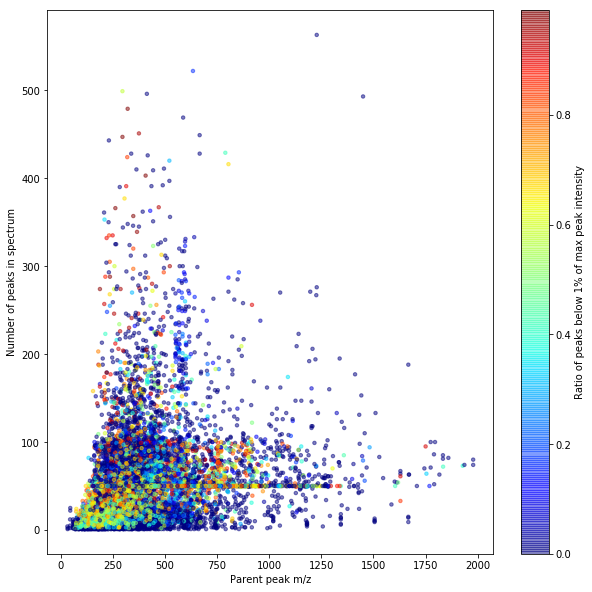

In [13]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)
plot_peak_stats(peak_count, parent_count, rel_to_max_count)  

## First impressions

All above methods work **get rid of the most excessive** amounts of peaks.

Using a min_peaks threshold further avoided the problem of **filtering out too many peaks**.

Now, however, many spectra are brought to exactly this minimum amount (see accumulation of dots around 50 peaks)!

### (4) Apply the intensity distribution based exponential cutoff filter 
+ fixed exp_intensity_filter = 0.01
+ use a min_peaks value that scales linearly with precursor m/z

In [14]:
spectra2 = copy.deepcopy(spectra)

min_peak_absolute = 10

# TEST: try to scale the min_peak filter
def min_peak_scaling(x, A, B):
    return int(A + B * x)

for spec in spectra2:
    peaks = spec.peaks.copy()
    min_peaks = min_peak_scaling(spec.precursor_mz, min_peak_absolute, 30/200)
    if len(peaks) > peaks_desired:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 0.0,
                     exp_intensity_filter = 0.01,
                     min_peaks = min_peaks,)

    spec.peaks = peaks

RuntimeError for  92  peaks. Use mean intensity as threshold.


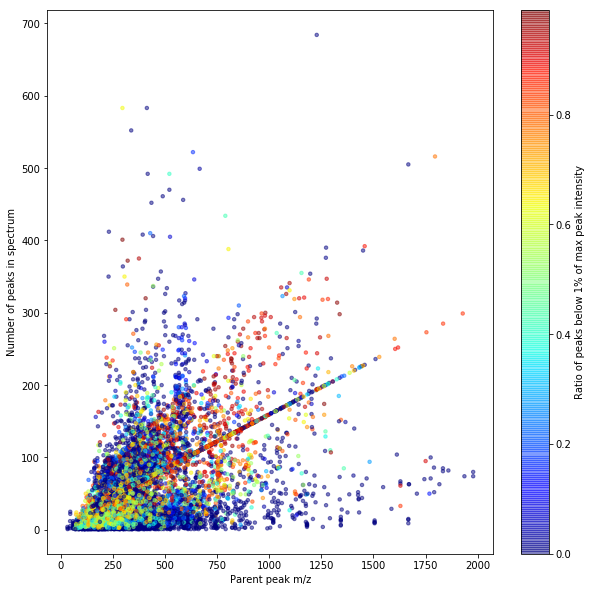

In [15]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)
plot_peak_stats(peak_count, parent_count, rel_to_max_count)  

### Remove spectra with too few peaks & create documents

In [16]:
min_peaks_absolute = 10
spectra_filtered = [copy.deepcopy(x) for x in spectra2 if len(x.peaks)>=min_peaks_absolute]
print("Take ", len(spectra_filtered), "peaks out of ", len(spectra), ".")

Take  9565 peaks out of  11134 .


In [17]:
MS_documents, MS_documents_intensity = MS_functions.create_MS_documents(spectra_filtered, 3)

  Created documents for  9565  of  9565  spectra.

In [18]:
# Have a look at how a document looks like:
print(MS_documents[0])

['peak_74.733', 'peak_79.017', 'peak_89.017', 'peak_89.038', 'peak_90.046', 'peak_95.046', 'peak_98.979', 'peak_105.045', 'peak_107.050', 'peak_117.034', 'peak_118.039', 'peak_134.672', 'peak_135.045', 'peak_135.276', 'peak_136.045', 'peak_136.998', 'peak_137.155', 'peak_145.030', 'peak_147.117', 'peak_160.087', 'peak_161.076', 'peak_162.587', 'peak_163.040', 'peak_163.077', 'peak_163.293', 'peak_164.042', 'peak_165.004', 'peak_165.400', 'peak_166.303', 'peak_167.149', 'peak_168.165', 'peak_172.581', 'peak_175.076', 'peak_181.057', 'peak_229.033', 'peak_237.012', 'peak_330.097', 'peak_330.142', 'loss_-0.023', 'loss_0.022', 'loss_93.107', 'loss_101.086', 'loss_149.062', 'loss_155.043', 'loss_157.538', 'loss_161.954', 'loss_162.970', 'loss_163.816', 'loss_164.719', 'loss_165.115', 'loss_166.077', 'loss_166.826', 'loss_167.042', 'loss_167.079', 'loss_167.532', 'loss_169.043', 'loss_170.032', 'loss_183.002', 'loss_185.089', 'loss_192.964', 'loss_193.121', 'loss_194.074', 'loss_194.843', 'l

In [19]:
len(MS_documents)  # number of spectra = number of documents

9565

#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [20]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [21]:
MS_measure.preprocess_documents(0.2, create_stopwords = False)

Preprocess documents...


### Word2Vec -based approach
Create Word2Vec based document centroid vectors.

Since spectra are built from manyn more possible words (much larger "dictionary"), vectors are reduced to 200 (instead of 100) dimensions.

In [22]:
file_model_word2vec = PATH_SAVE_DATA + 'model_w2v_MS_gnps_uniquesmiles_d200.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=200, window=50, 
                             min_count=1, workers=4, iter=250, 
                             use_stored_model=True)

Load stored word2vec model ...


In [23]:
MS_measure.get_vectors_centroid(weighted=True)
MS_measure.get_centroid_distances(num_hits=25, method='cosine')

  Calculated centroid vectors for  9565  of  9565  documents.of  9565  documents. documents.1940  of  9565  documents.9565  documents.9565  documents.  documents. Calculated centroid vectors for  8010  of  9565  documents. Calculated centroid vectors for  8140  of  9565  documents. 8390  of  9565  documents.

This has calculated (cosine) distances between all spectra in an all-vs-all fashion.
The "num_hits" closest candidates for each spectrum are listed in two matrices.

One stores the distances, the other the respective IDs.

In [24]:
MS_measure.Cdistances_ctr[1,:]

array([1.11022302e-16, 3.06451119e-01, 3.19386721e-01, 3.37007441e-01,
       3.58437417e-01, 3.86749648e-01, 3.92855004e-01, 3.96727362e-01,
       4.03409565e-01, 4.15336485e-01, 4.28334141e-01, 4.39830509e-01,
       4.39860313e-01, 4.43941366e-01, 4.45036281e-01, 4.50054845e-01,
       4.50080837e-01, 4.54071296e-01, 4.54758893e-01, 4.60814192e-01,
       4.65129405e-01, 4.65488650e-01, 4.65683684e-01, 4.68162069e-01,
       4.72787393e-01])

In [25]:
MS_measure.Cdistances_ctr_idx[1,:]

array([   1,  304,  137,   79,  559,  110,  892,  244,  621,  249, 1048,
       9276,   68, 1671,  506,  658, 8938,  953,  527,  498, 8664, 8594,
       8483, 1953, 8482])

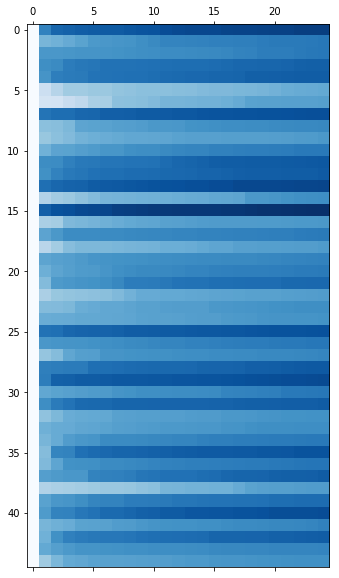

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(MS_measure.Cdistances_ctr[:45,:25], cmap=plt.cm.Blues)

### Plot molecules from smiles to visually compare selected spectra

In [36]:
from rdkit import Chem
from rdkit.Chem import Draw

def plot_smiles(query_id, spectra, MS_measure, num_candidates = 10,
                   sharex=True, labels=False, dist_method = "centroid",
                   plot_type = "single"):
    """ Plot molecules for closest candidates
    
    """

    # Select chosen distance methods
    if dist_method == "centroid":
        candidates_idx = MS_measure.Cdistances_ctr_idx[query_id, :num_candidates]
        candidates_dist = MS_measure.Cdistances_ctr[query_id, :num_candidates]
    elif dist_method == "pca":
        candidates_idx = MS_measure.Cdistances_pca_idx[query_id, :num_candidates]
        candidates_dist = MS_measure.Cdistances_pca[query_id, :num_candidates]
    elif dist_method == "autoencoder":
        candidates_idx = MS_measure.Cdistances_ae_idx[query_id, :num_candidates]
        candidates_dist = MS_measure.Cdistances_ae[query_id, :num_candidates]
    elif dist_method == "lda":
        candidates_idx = MS_measure.Cdistances_lda_idx[query_id, :num_candidates]
        candidates_dist = MS_measure.Cdistances_lda[query_id, :num_candidates]
    elif dist_method == "lsi":
        candidates_idx = MS_measure.Cdistances_lsi_idx[query_id, :num_candidates]
        candidates_dist = MS_measure.Cdistances_lsi[query_id, :num_candidates]
    elif dist_method == "doc2vec":
        candidates_idx = MS_measure.Cdistances_d2v_idx[query_id, :num_candidates]
        candidates_dist = MS_measure.Cdistances_d2v[query_id, :num_candidates]
    else:
        print("Chosen distance measuring method not found.")

    size = (200, 200)  # Smaller figures than the default

    if isinstance(spectra, dict):
        # If spectra is given as a dictionary
        keys = []
        for key, value in spectra.items():
            keys.append(key)  
            
        smiles = []  
        molecules = []
        for i, candidate_id in enumerate(candidates_idx):
            key = keys[candidate_id]
            smiles.append(spectra[key]["smiles"])
            mol = Chem.MolFromSmiles(smiles[i])
            mol.SetProp('_Name', smiles[i])
            if plot_type == 'single':
                Draw.MolToMPL(mol, size=size)
        
        if plot_type != "single":    # this will only work if there's no conflict with rdkit and pillow...       
            Chem.Draw.MolsToGridImage(molecules,legends=[mol.GetProp('_Name') for mol in molecules])
            
    elif isinstance(spectra, list):
        # Assume that it is then a list of Spectrum objects
        
        smiles = []  
        for i, candidate_id in enumerate(candidates_idx):
            smiles.append(spectra[candidate_id].metadata["smiles"])
            mol = Chem.MolFromSmiles(smiles[i])
            mol.SetProp('_Name', smiles[i])
            if plot_type == 'single':
                Draw.MolToMPL(mol, size=size)
        
        if plot_type != "single":    # this will only work if there's no conflict with rdkit and pillow...       
            Chem.Draw.MolsToGridImage(molecules,legends=[mol.GetProp('_Name') for mol in molecules])


In [45]:
print(len(MS_measure.dictionary))

193088


[0.         0.25229161 0.25341736 0.260797   0.27913471 0.29197474
 0.30249045 0.31629322 0.33146556 0.34365191]


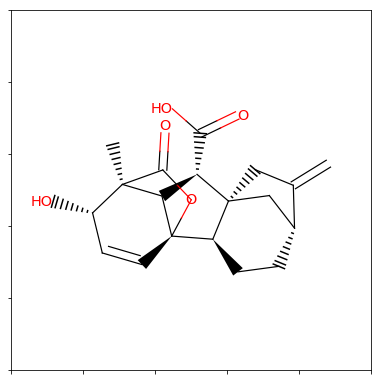

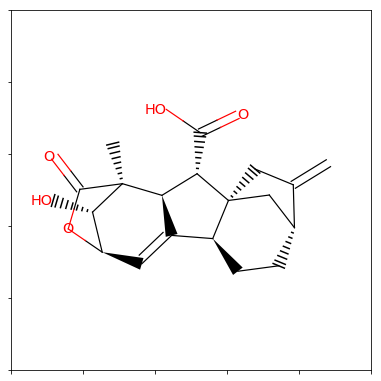

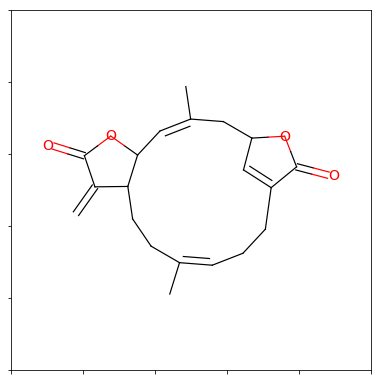

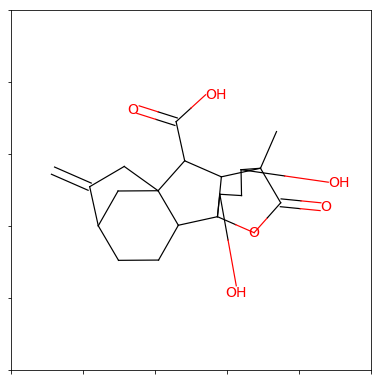

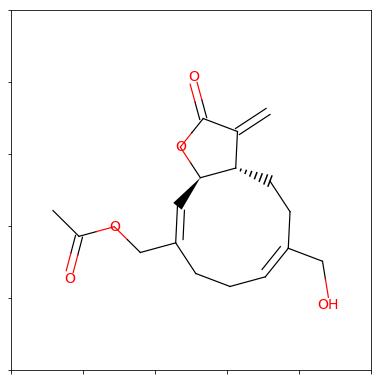

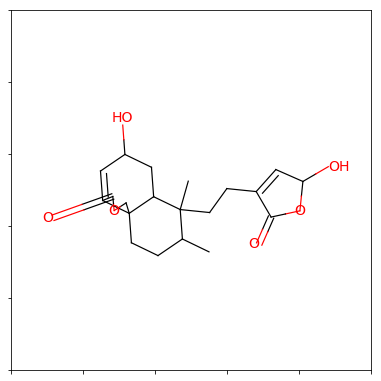

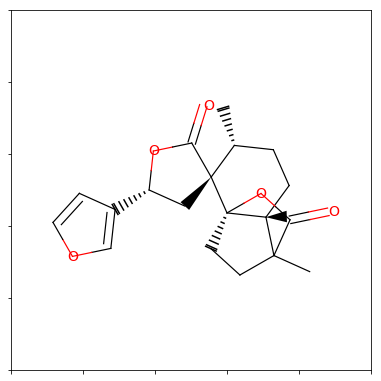

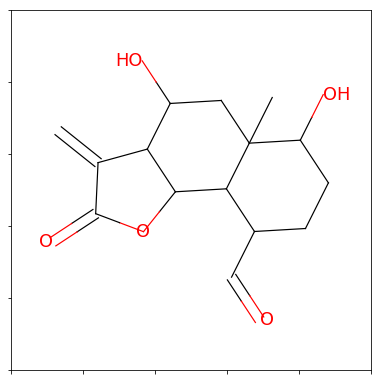

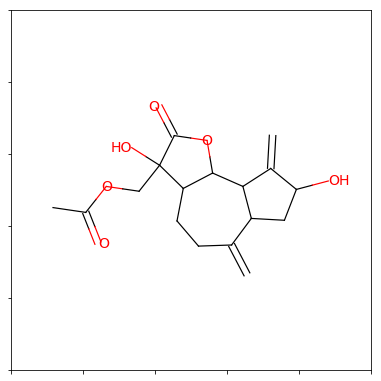

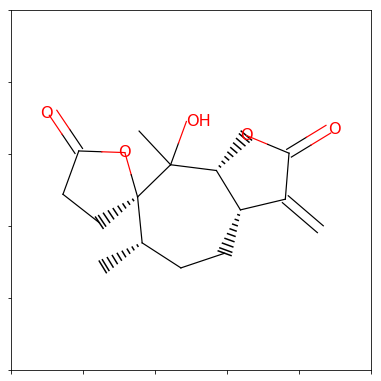

In [51]:
query_id = 2001
print(MS_measure.Cdistances_ctr[query_id, :10])
plot_smiles(query_id, spectra_filtered, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "centroid")

### Try different similarity measuring methods...

#### A) Autoencoder
Will train a deep autoencoder to generate 100 dimensional (or = encoding_dim) vectors representing each document. 

In [10]:
file_model_ae = 'data\\model_autoencoder_MS_ref.h5'
file_model_encoder = 'data\\model_encoder_MS_ref.h5'
MS_measure.build_autoencoder(file_model_ae, file_model_encoder, 
                             epochs = 10, batch_size = 1024, encoding_dim = 200,
                            layer_factors = (2,2,1))

No stored model found!
Creating new autoencoder model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               14287200  
_________________________________________________________________
dense_2 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_7 (Dense)    

In [11]:
MS_measure.get_autoencoder_distances(num_hits=25, method='cosine')

[0.00000000e+00 5.00042002e-08 5.45181902e-08 5.70141371e-08
 5.73981184e-08 5.94601914e-08 6.16103938e-08 6.17372152e-08
 6.28124363e-08 6.40211500e-08]


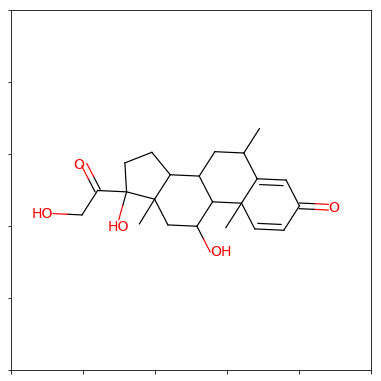

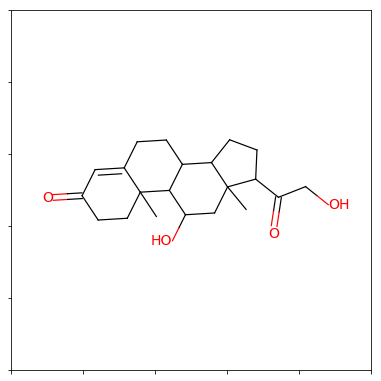

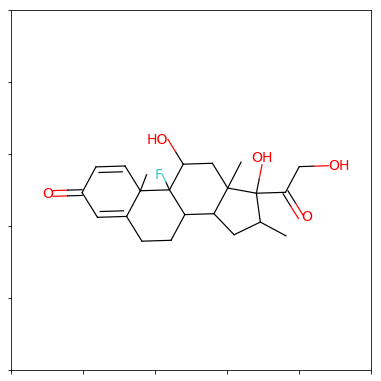

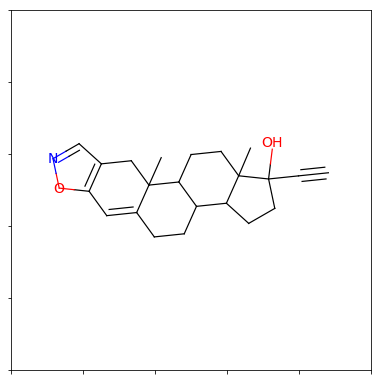

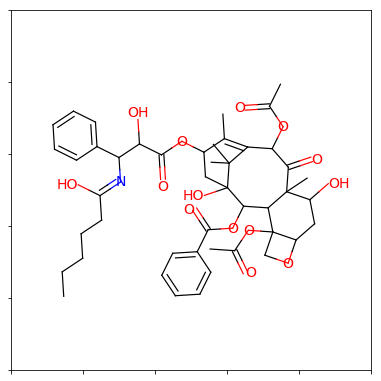

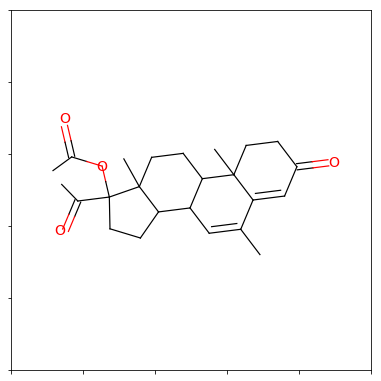

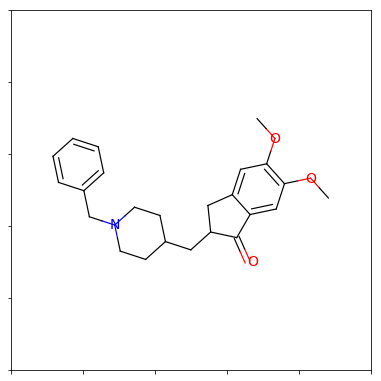

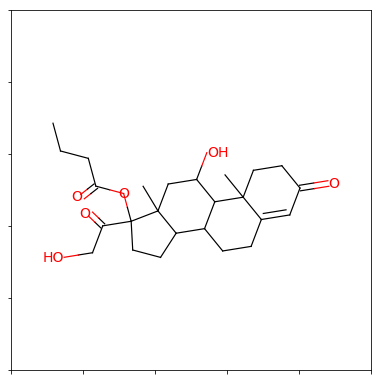

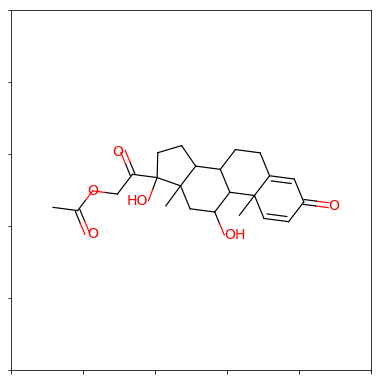

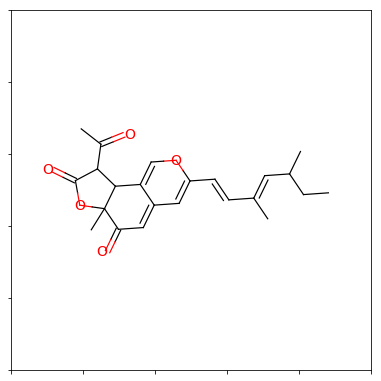

In [13]:
query_id = 85
print(MS_measure.Cdistances_ae[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "autoencoder")

#### B) PCA
Will calulate 300 dimensional representations of each document using PCA.

In [ ]:
MS_measure.get_vectors_pca(300)

In [15]:
MS_measure.get_pca_distances(num_hits=25, method='cosine')

[0.         0.30405108 0.4850395  0.49591485 0.51674513 0.52593692
 0.56705579 0.60093781 0.6120955  0.63350553]


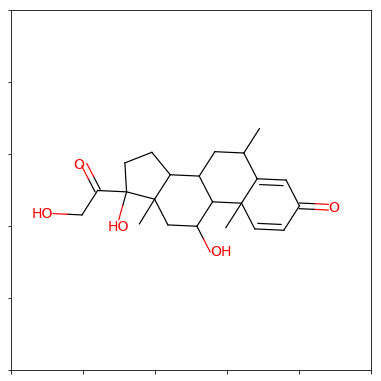

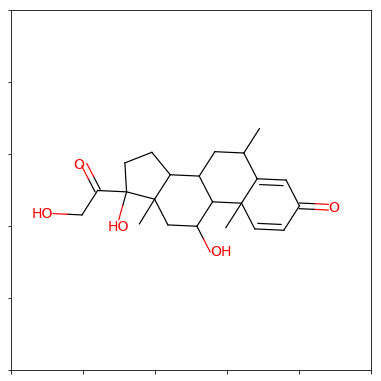

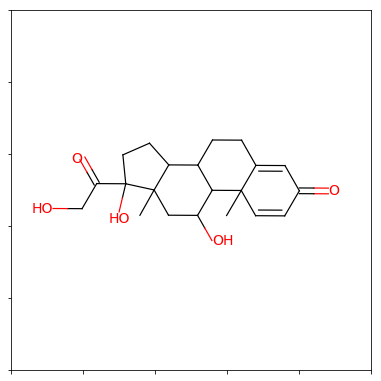

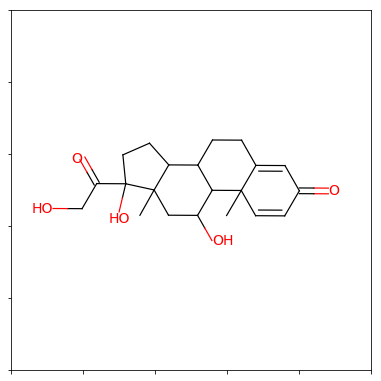

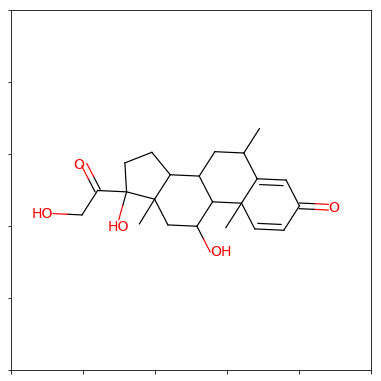

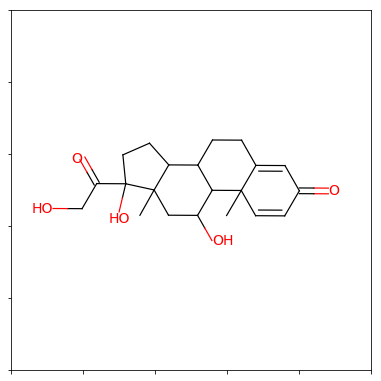

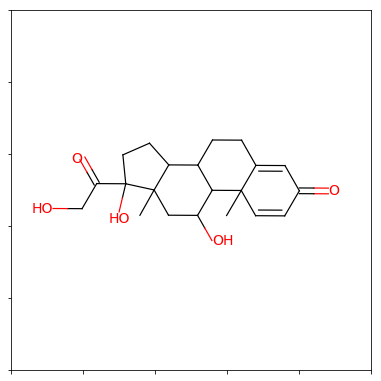

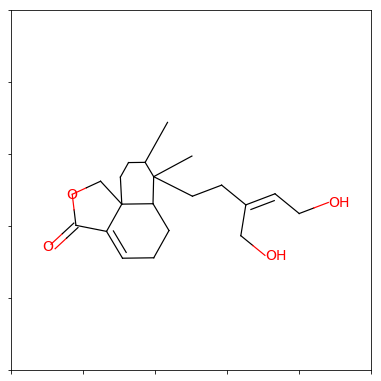

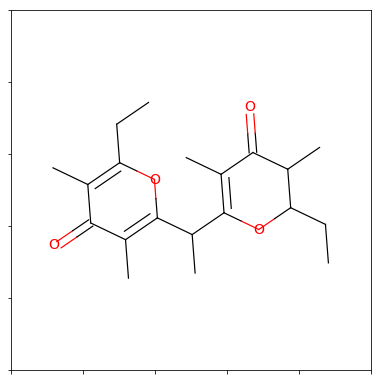

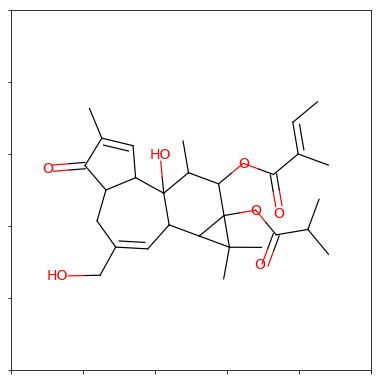

In [17]:
query_id = 85
print(MS_measure.Cdistances_pca[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "pca")

#### C) Doc2Vec
Will calulate 100 dimensional representations of each document using Doc2Vec.

In [18]:
file_model_doc2vec = "data\\model_doc2vec_MS_ref.model"
MS_measure.build_model_doc2vec(file_model_doc2vec, vector_size=200, window=50, 
                             min_count=1, workers=4, epochs=250, 
                             use_stored_model=True)

Stored doc2vec model not found!
Calculating new doc2vec model...


In [19]:
MS_measure.get_doc2vec_distances(num_hits=25, method='cosine')

[1.11022302e-16 1.88275285e-01 2.07867229e-01 2.09121450e-01
 2.18596212e-01 2.21561493e-01 2.22052251e-01 2.24888663e-01
 2.25114061e-01 2.27962206e-01]


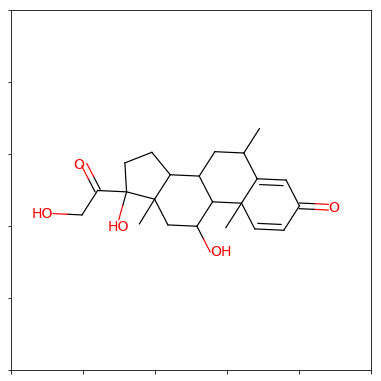

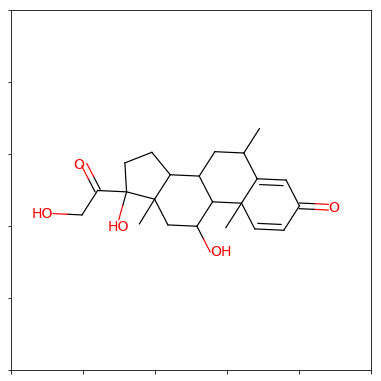

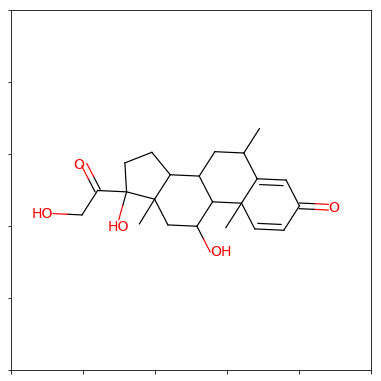

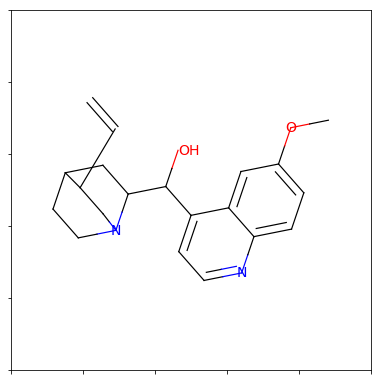

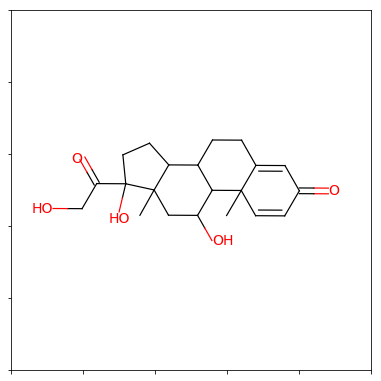

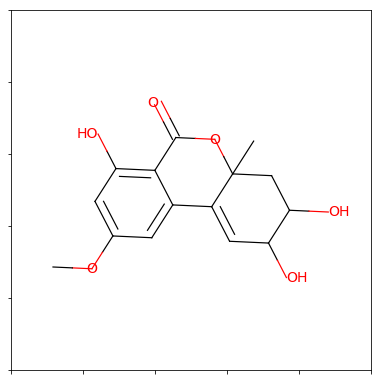

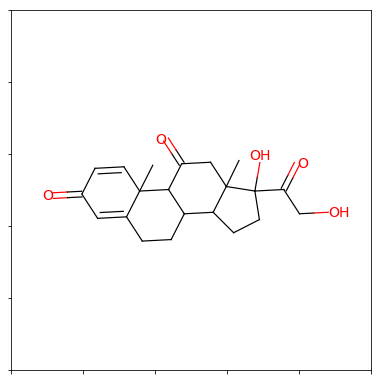

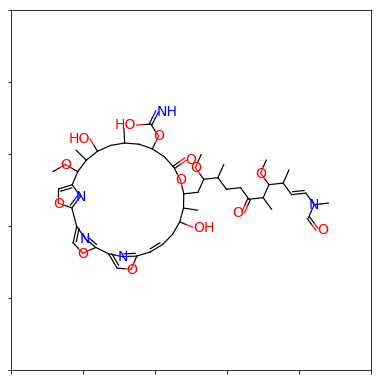

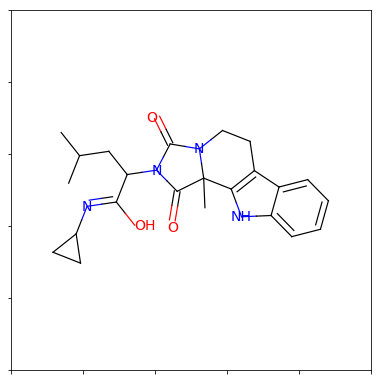

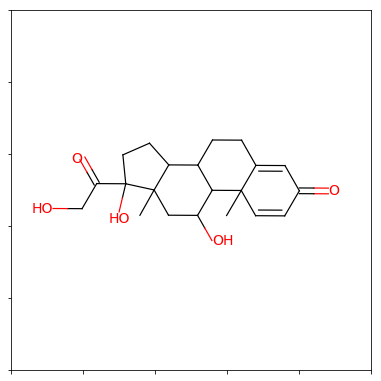

In [20]:
query_id = 85
print(MS_measure.Cdistances_d2v[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "doc2vec")

#### D) LDA
Will calulate document distances using LDA.

In [21]:
file_model_lda = "data\\model_lda_MS_ref.model"
MS_measure.build_model_lda(file_model_lda, num_of_topics=200, num_pass=4, 
                        num_iter=100, use_stored_model=True)

Stored LDA model not found!
Calculating new LDA model...


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\gensim\models\ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


'Keyword in the 10 topics'
[(126,
  '0.032*"loss_45.021" + 0.013*"peak_196.076" + 0.011*"loss_30.010" + '
  '0.011*"peak_253.195" + 0.009*"peak_183.092" + 0.008*"loss_58.030" + '
  '0.008*"peak_157.084" + 0.008*"peak_236.071" + 0.008*"peak_156.081" + '
  '0.007*"peak_125.017"'),
 (117,
  '0.014*"peak_93.034" + 0.011*"peak_184.084" + 0.011*"peak_186.066" + '
  '0.009*"peak_108.046" + 0.009*"loss_161.082" + 0.009*"peak_152.069" + '
  '0.009*"loss_72.056" + 0.007*"peak_201.053" + 0.007*"peak_169.067" + '
  '0.007*"peak_221.088"'),
 (175,
  '0.011*"loss_131.040" + 0.011*"peak_148.062" + 0.011*"peak_104.056" + '
  '0.011*"peak_147.065" + 0.011*"loss_189.173" + 0.011*"loss_164.131" + '
  '0.010*"peak_93.071" + 0.010*"peak_120.079" + 0.009*"loss_122.096" + '
  '0.009*"loss_207.127"'),
 (4,
  '0.008*"peak_274.107" + 0.007*"peak_103.055" + 0.007*"peak_104.059" + '
  '0.007*"peak_135.041" + 0.007*"loss_290.127" + 0.006*"peak_219.100" + '
  '0.006*"loss_164.080" + 0.006*"peak_254.091" + 0.005*"lo

In [22]:
MS_measure.get_lda_distances(num_hits=25)

[0.         0.07840133 0.07840133 0.07840133 0.07840133 0.07888448
 0.07917434 0.08557528 0.16380405 0.17856294]


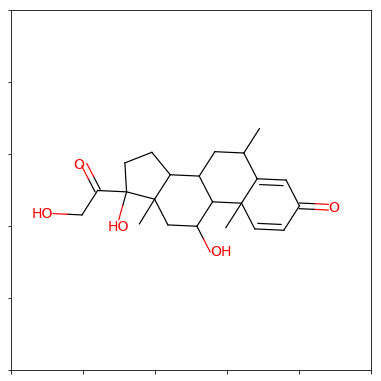

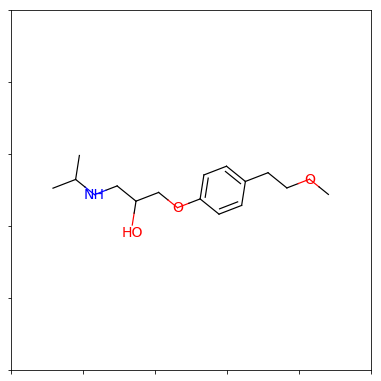

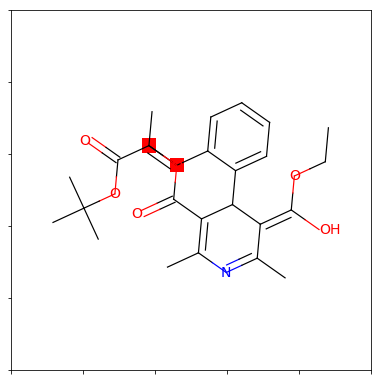

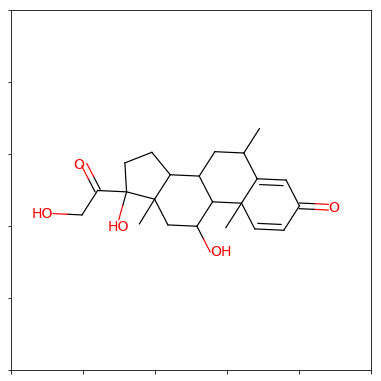

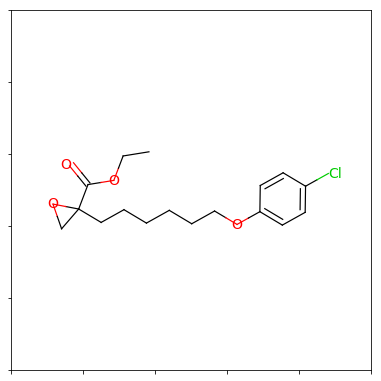

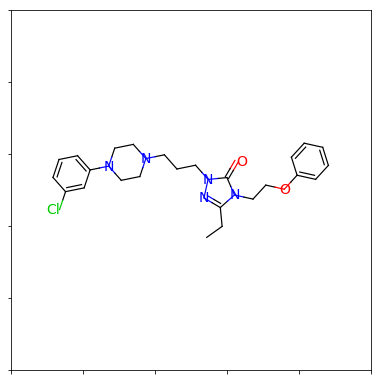

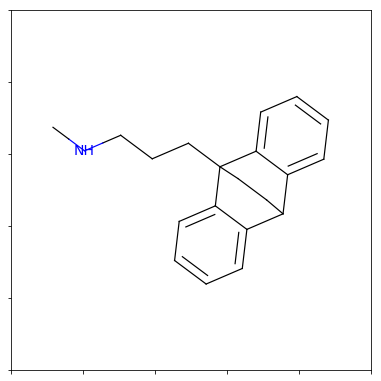

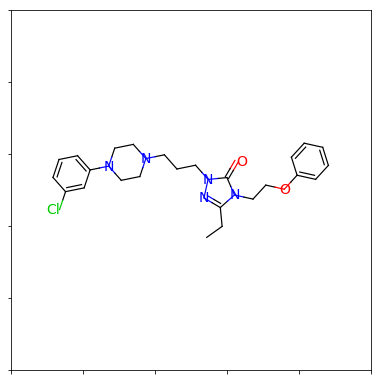

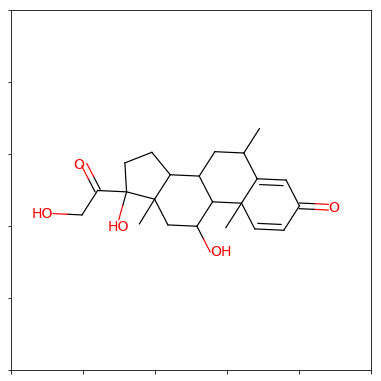

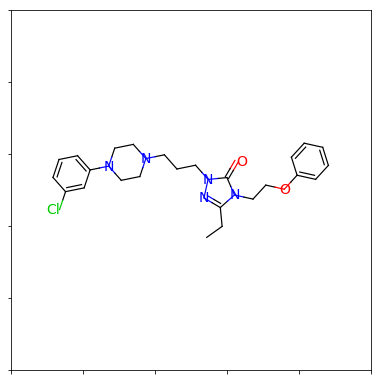

In [23]:
query_id = 85
print(MS_measure.Cdistances_lda[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "lda")

#### E) LSI
Will calulate document distances using LSI.

In [24]:
file_model_lsi = "data\\model_lsi_MS_ref.model"
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=200, 
                             use_stored_model=True)

Stored LSI model not found!
Calculating new LSI model...


In [25]:
MS_measure.get_lsi_distances(num_hits=25)

[0.         0.07875121 0.07875121 0.07875121 0.07875121 0.07923418
 0.0795384  0.08596176 0.16356981 0.178873  ]


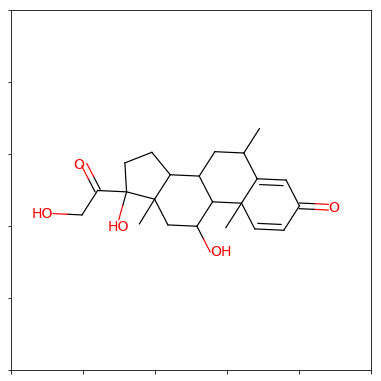

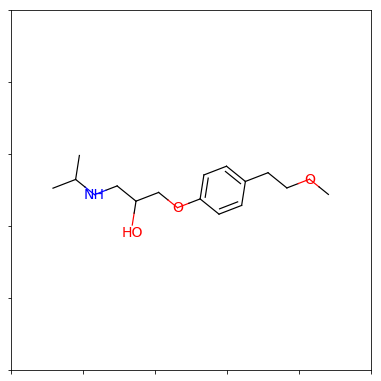

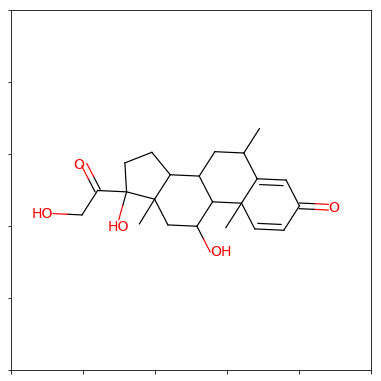

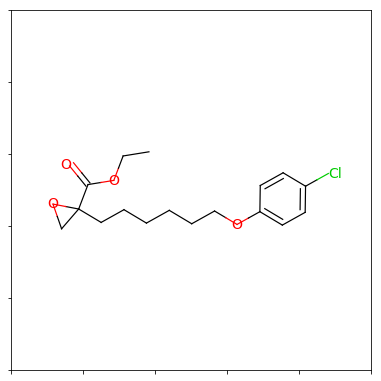

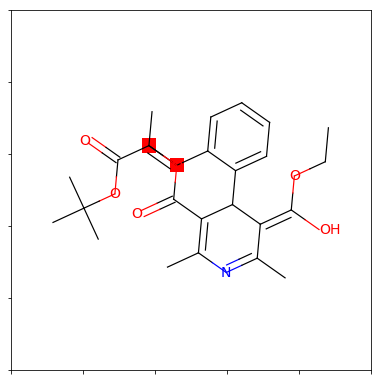

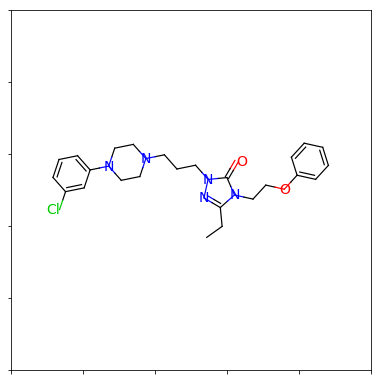

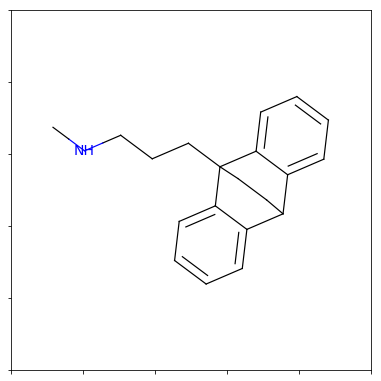

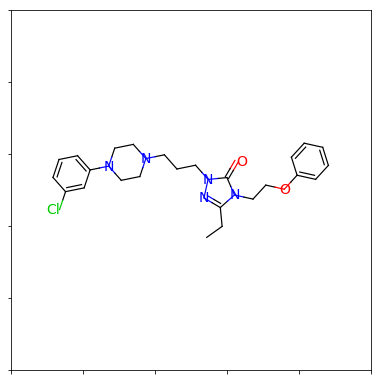

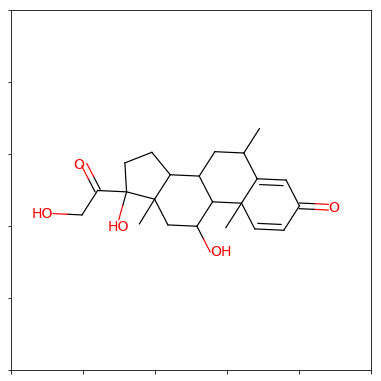

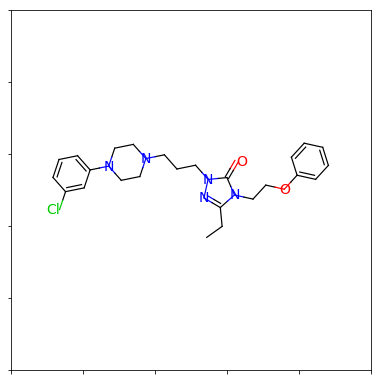

In [26]:
query_id = 85
print(MS_measure.Cdistances_lsi[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "lsi")